### Statistics of unconditional generated rules.

In [1]:
import sys
# sys.path.append("/n/home12/binxuwang/Github/mini_edm")
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")

In [2]:
import os
from os.path import join
import pickle as pkl
import torch
from easydict import EasyDict as edict
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import einops
import json


In [3]:
expdir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256"

In [9]:
data = np.load(join(expdir, "samples_inferred_rule_consistency_new.npz"), allow_pickle=True)
list(data.keys())
from copy import deepcopy
rule_list_all = deepcopy(data['rule_list_all'])


['consistency_all', 'rule_list_all', 'epoch_list']

In [29]:
print(data['epoch_list'])
print(len(data['epoch_list']))

[      1    1000    2000 ... 1003000 1004000 1005000]
1006


In [10]:
print(data['rule_list_all'].shape)
print(data['rule_list_all'].dtype)

(1006, 1024, 3)
object


In [12]:
# last sample in last generation
data['rule_list_all'][-1,-1]

array([array([26]), array([26]), array([26])], dtype=object)

In [23]:
# Concanate all the rules for all the samples in the last generation. ignore the invalid rules
rule_pool = np.concatenate(list(data['rule_list_all'][-1,:,:].flatten())).astype(int)

In [ ]:
print(len(rule_pool))

2490


The held out rules for this training dataset are [1, 16, 20, 34, 37]. So generation of these rules are kind of generalization in the rule space. 

In [ ]:
# Count the occurrence of each rule using pandas
rule_counts = pd.Series(rule_pool).value_counts()
print(rule_counts)

12    106
26    105
35    104
39    102
25    102
38     99
5      95
10     95
13     94
30     93
2      92
15     90
24     87
6      87
36     86
33     83
23     78
22     76
21     72
14     72
11     67
32     63
9      62
4      62
31     60
3      54
0      51
7      49
16     45
8      45
18     27
28     25
29     20
20     18
19     13
17      5
27      4
37      1
1       1
Name: count, dtype: int64


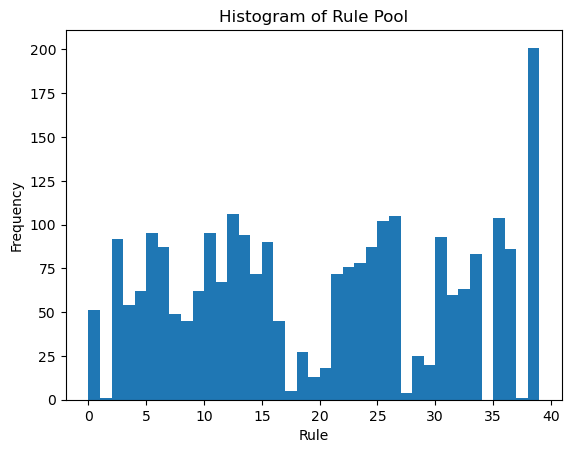

In [ ]:
# Histogram of rule pool
plt.hist(rule_pool, bins=len(np.unique(rule_pool)))
plt.xlabel('Rule')
plt.ylabel('Frequency')
plt.title('Histogram of Rule Pool')
plt.show()

### Synopsis of all rules learning dynamics

In [31]:
from copy import deepcopy
rule_list_all = deepcopy(data['rule_list_all']) 
# this line is needed because otherwise it can be excruciatingly slow to access the ragged data. 

In [38]:
rule_list_all.shape

(1006, 1024, 3)

In [42]:
from tqdm import trange
rule_pool_all = []
for i in trange(len(data['epoch_list'])):
    rule_pool = np.concatenate(list(rule_list_all[i,:,:].flatten())).astype(int)
    rule_pool_all.append(rule_pool)

100%|██████████| 1006/1006 [00:00<00:00, 1489.52it/s]


In [43]:
# each element in the rule rule_pool_all is a list of rules for all the samples in the corresponding generation
# plot the number of rules == rule_i for each generation
rule_cnt_mat = np.zeros((len(data['epoch_list']), 40))
for i in trange(len(data['epoch_list'])):
    rule_pool = rule_pool_all[i]
    rule_uniq, counts = np.unique(rule_pool, return_counts=True)
    rule_cnt_mat[i, rule_uniq] = counts

100%|██████████| 1006/1006 [00:00<00:00, 13221.38it/s]


In [48]:
row_table = {
0: "Constant",
1: "Progression neg 2",
2: "Progression neg 1",
3: "Progression pos 1",
4: "Progression pos 2",
5: "Arithmetic pos",
6: "Arithmetic neg",
7: "XOR",
8: "OR",
9: "AND"
}
col_table =  {0: "Shape", 1: "Size", 2: "Color", 3: "Number", 4: "Position"}
entry_table = {}
for i in range(40):
    if i < 37:
        entry_table[i] = f"{row_table[i%10]}-{col_table[i//10]}"
    else:
        entry_table[i] = f"{row_table[i%10]}-{col_table[i//10+1]}"
print(entry_table)

{0: 'Constant-Shape', 1: 'Progression neg 2-Shape', 2: 'Progression neg 1-Shape', 3: 'Progression pos 1-Shape', 4: 'Progression pos 2-Shape', 5: 'Arithmetic pos-Shape', 6: 'Arithmetic neg-Shape', 7: 'XOR-Shape', 8: 'OR-Shape', 9: 'AND-Shape', 10: 'Constant-Size', 11: 'Progression neg 2-Size', 12: 'Progression neg 1-Size', 13: 'Progression pos 1-Size', 14: 'Progression pos 2-Size', 15: 'Arithmetic pos-Size', 16: 'Arithmetic neg-Size', 17: 'XOR-Size', 18: 'OR-Size', 19: 'AND-Size', 20: 'Constant-Color', 21: 'Progression neg 2-Color', 22: 'Progression neg 1-Color', 23: 'Progression pos 1-Color', 24: 'Progression pos 2-Color', 25: 'Arithmetic pos-Color', 26: 'Arithmetic neg-Color', 27: 'XOR-Color', 28: 'OR-Color', 29: 'AND-Color', 30: 'Constant-Number', 31: 'Progression neg 2-Number', 32: 'Progression neg 1-Number', 33: 'Progression pos 1-Number', 34: 'Progression pos 2-Number', 35: 'Arithmetic pos-Number', 36: 'Arithmetic neg-Number', 37: 'XOR-Position', 38: 'OR-Position', 39: 'AND-Positi

In [74]:
def visualize_indiv_rule_dynam(rule_mat, conv_wid=10, titlestr="Valid rule count separated by rule type", ylabel="Count", axs=None):
    # remove top and right spines from plot with plt
    plt.rcParams.update({'font.size': 12})
    if axs is None:
        figh, axs = plt.subplots(4, 10, figsize=(30, 12.5), sharex=True, sharey=True)
    else:
        figh = axs[0,0].get_figure()
    axs_f = axs.flatten()
    for i in range(40):
        ax = axs_f[i]
        # smooth the curve
        smooth_rule_cnt = np.convolve(rule_mat[:,i], np.ones(conv_wid)/conv_wid, mode='same')
        ax.plot(data['epoch_list'], smooth_rule_cnt, alpha=0.7, )
        ax.set_title(f"R{i}: {entry_table[i]}")
        # change the font color of title to red
        if i in [1, 16, 20, 34, 37]:
            ax.title.set_color('red')
        if i >= 30:
            ax.set_xlabel("generation")
        if i % 10 == 0:
            ax.set_ylabel(ylabel)
    figh.suptitle(titlestr, fontsize=20)
    figh.tight_layout()
    figh.show()
    return figh, axs

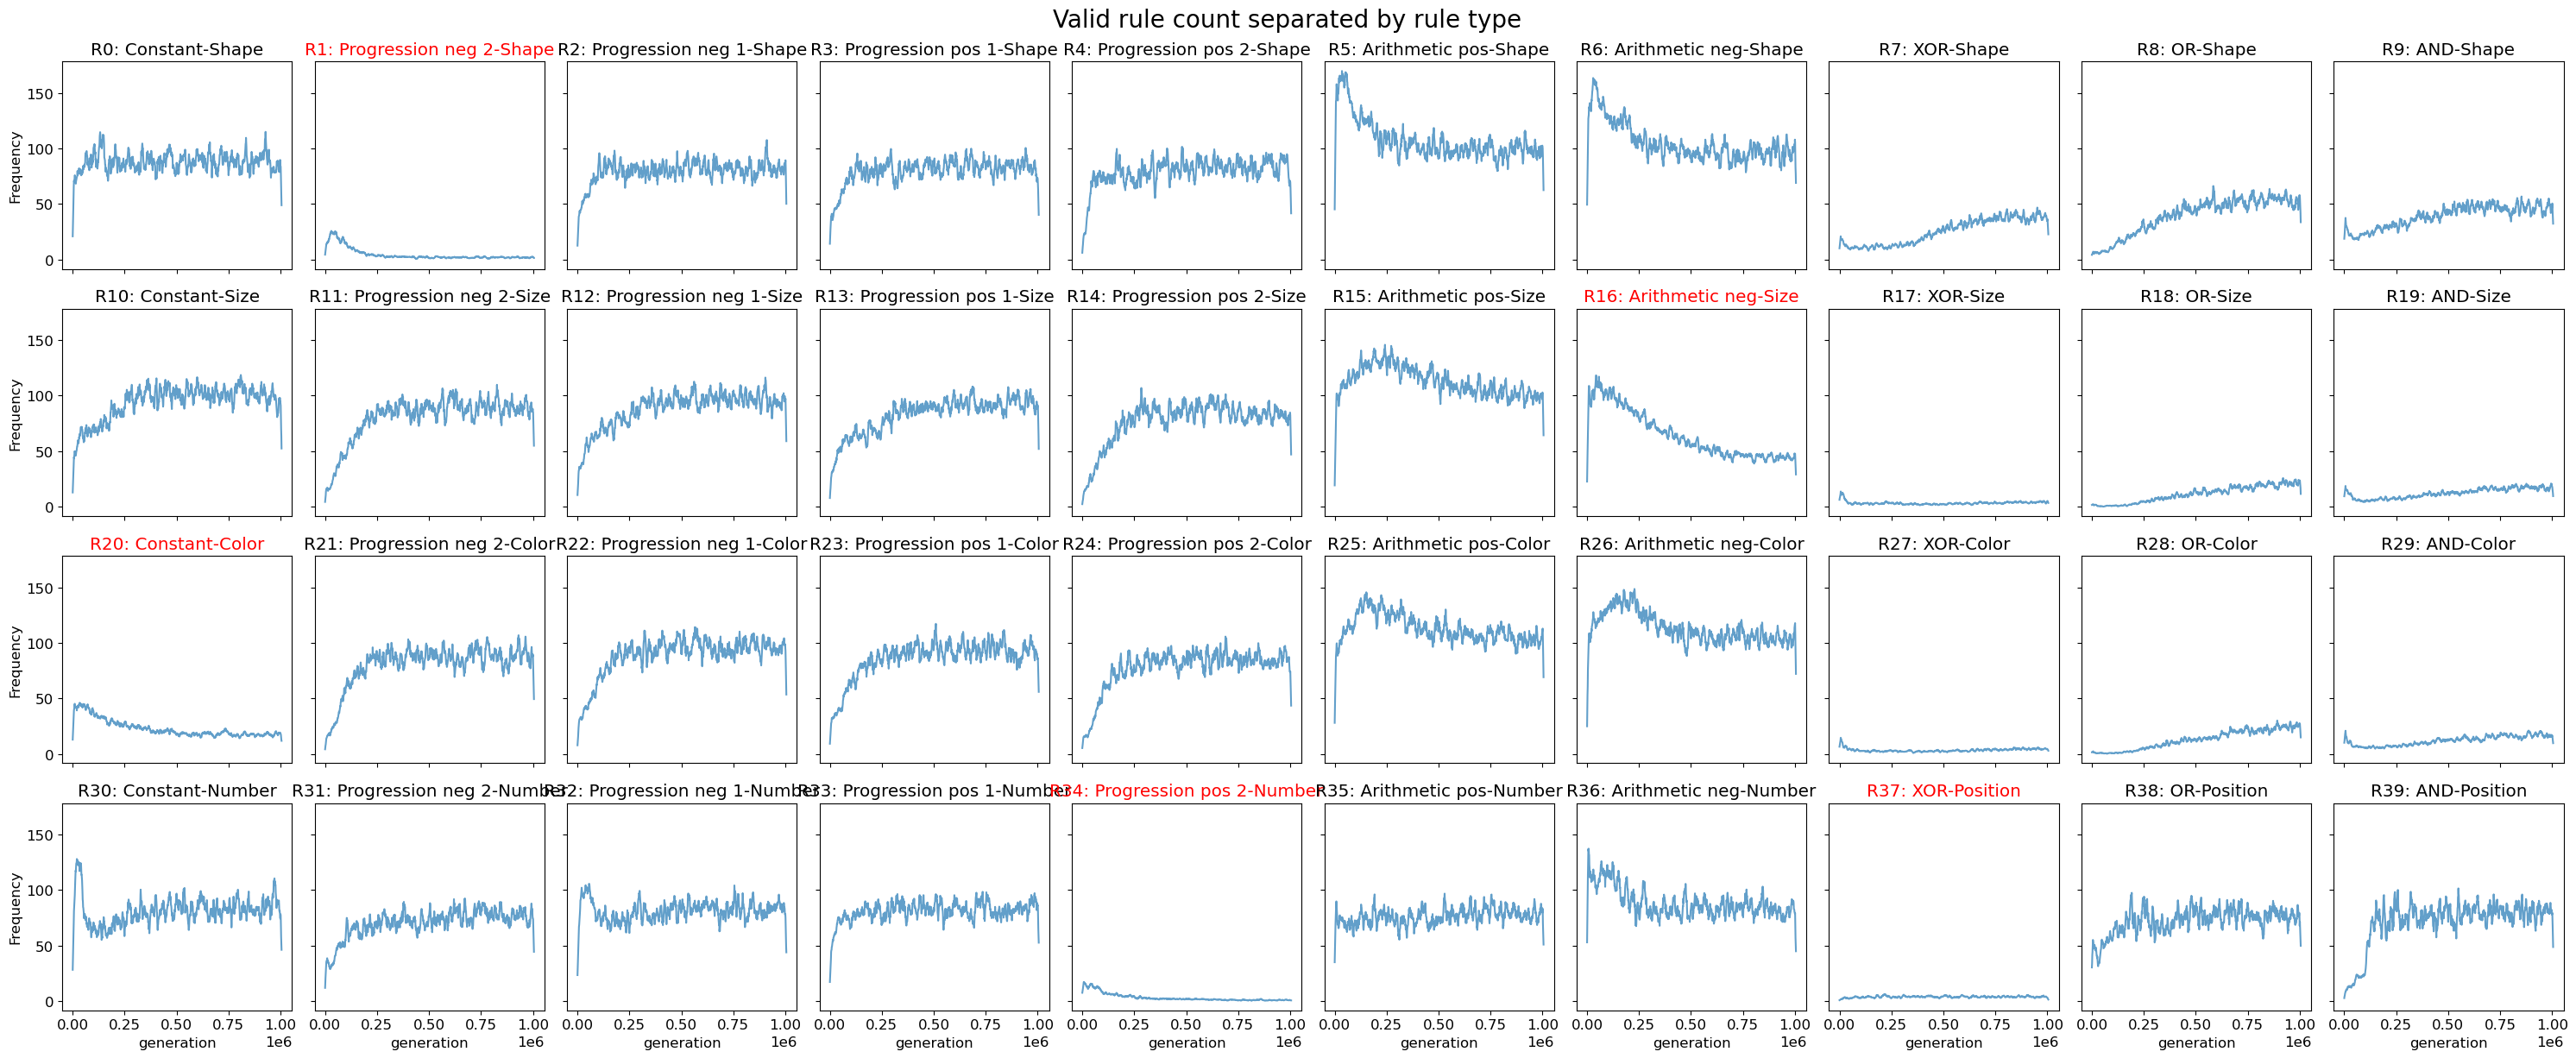

In [69]:
figh, axs = visualize_indiv_rule_dynam(rule_cnt_mat, conv_wid=10, titlestr="Valid rule count separated by rule type")

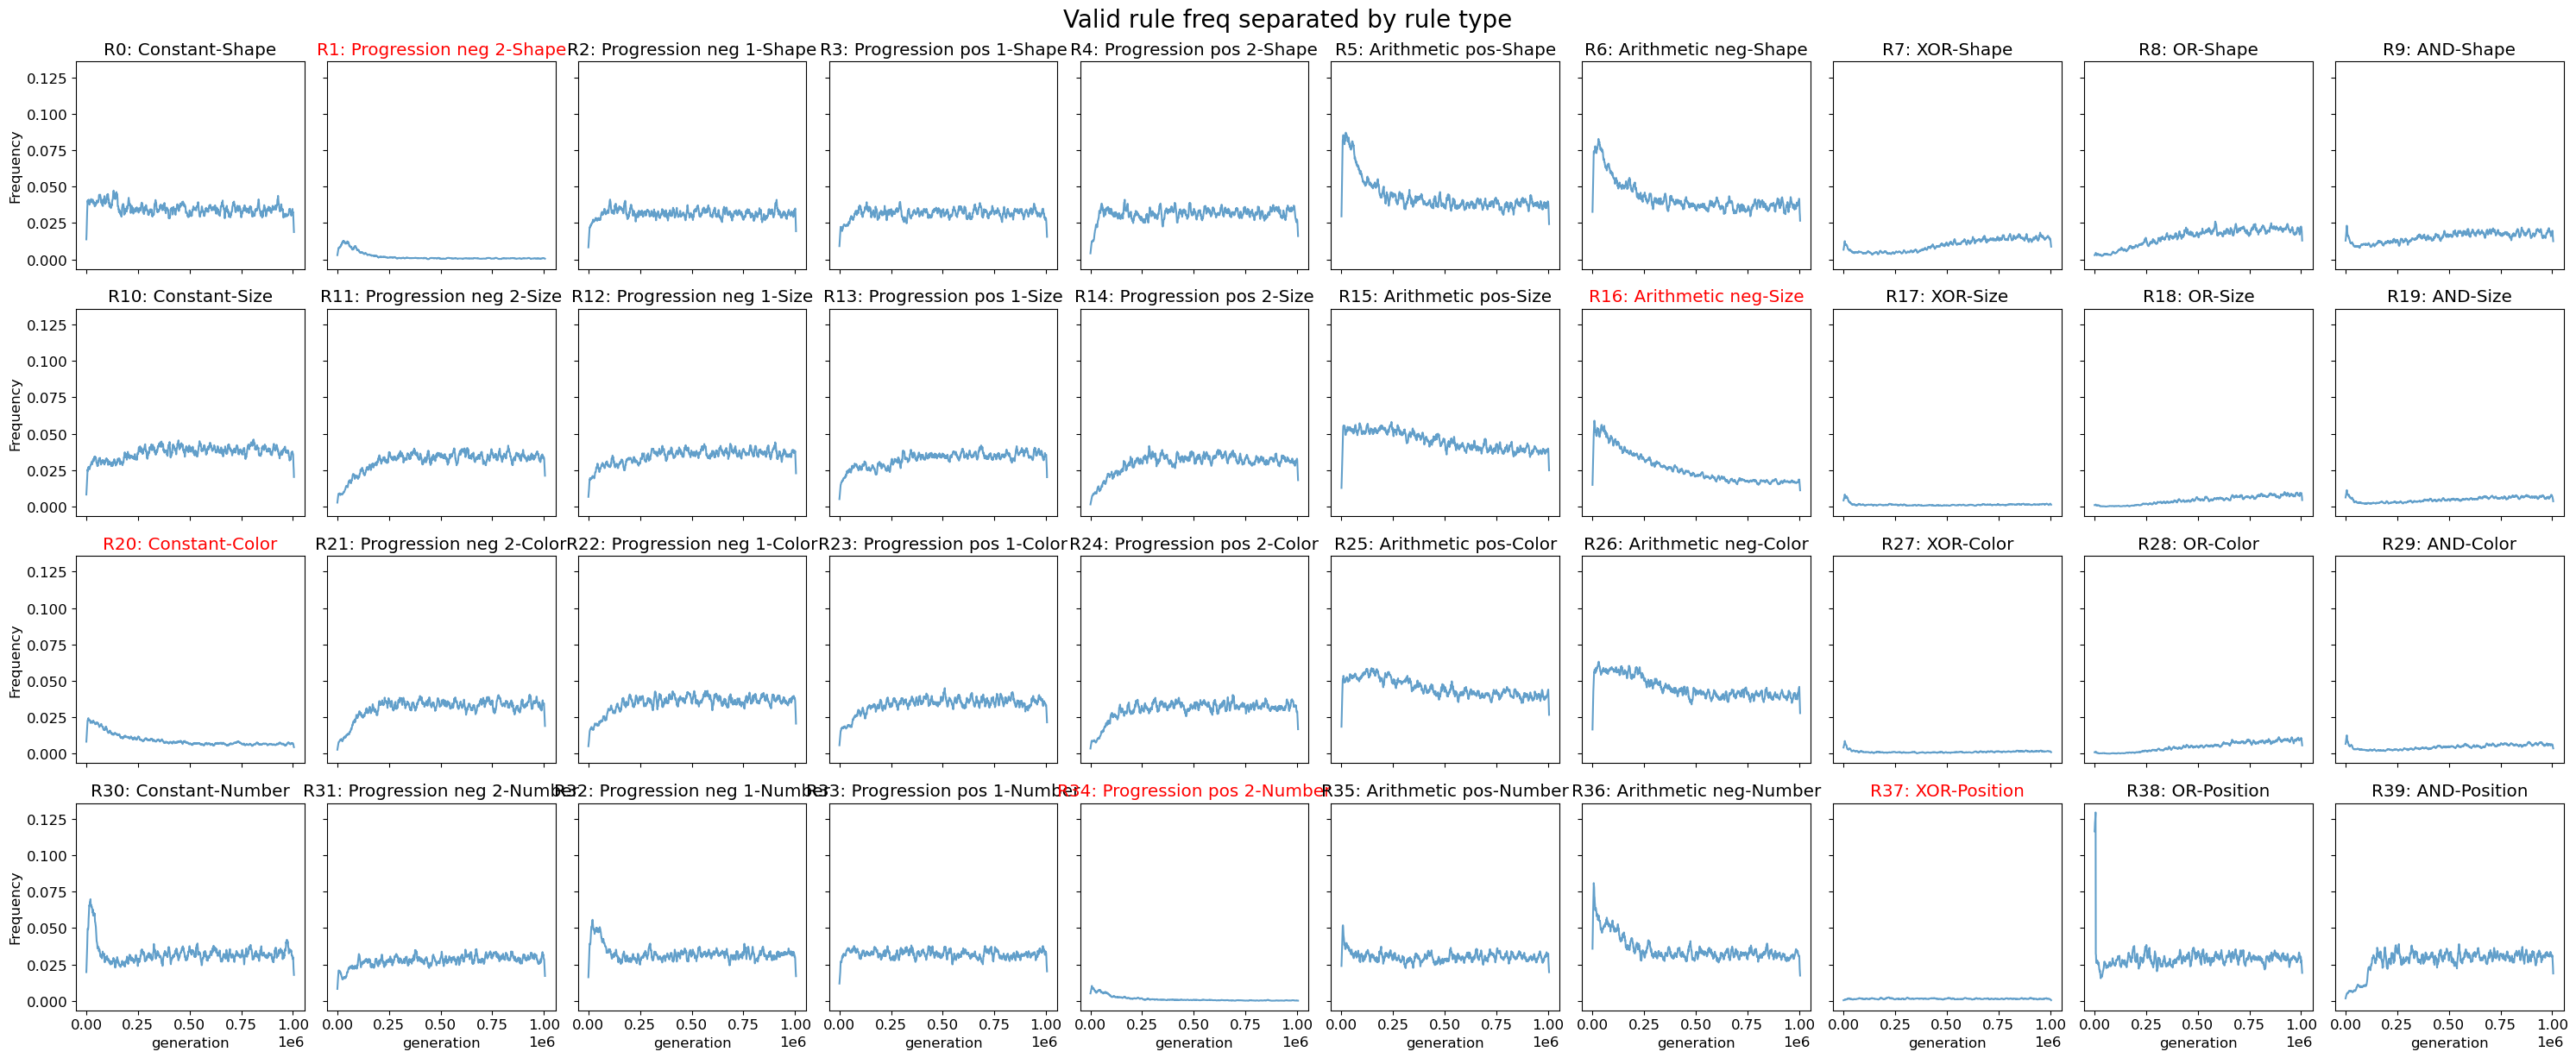

In [71]:
figh, axs = visualize_indiv_rule_dynam(rule_cnt_mat / rule_cnt_mat.sum(axis=1, keepdims=True), conv_wid=10,
                                       titlestr="Valid rule freq separated by rule type", ylabel="Frequency")

### Distribution of consistent panels

In [56]:
consistency_all = deepcopy(data['consistency_all'])
# this line is needed because otherwise it can be excruciatingly slow to access the data. 

In [60]:
consistency_all[:,0,:]
cons3_rule_pool_all = []
cons2_rule_pool_all = []
for i in trange(len(data['epoch_list'])):
    rule_pool = np.concatenate(list(consistency_all[i,0,:].flatten())).astype(int)
    cons3_rule_pool_all.append(rule_pool)
    rule_pool = np.concatenate(list(consistency_all[i,1,:].flatten())).astype(int)
    cons2_rule_pool_all.append(rule_pool)

cons3_rule_cnt_mat = np.zeros((len(data['epoch_list']), 40))
cons2_rule_cnt_mat = np.zeros((len(data['epoch_list']), 40))
for i in trange(len(data['epoch_list'])):
    rule_pool = cons3_rule_pool_all[i]
    rule_uniq, counts = np.unique(rule_pool, return_counts=True)
    cons3_rule_cnt_mat[i, rule_uniq] = counts
    rule_pool = cons2_rule_pool_all[i]
    rule_uniq, counts = np.unique(rule_pool, return_counts=True)
    cons2_rule_cnt_mat[i, rule_uniq] = counts

100%|██████████| 1006/1006 [00:00<00:00, 23200.34it/s]


/tmp/ipykernel_3395043/2318744368.py:23: UserWarning: The figure layout has changed to tight
  figh.tight_layout()


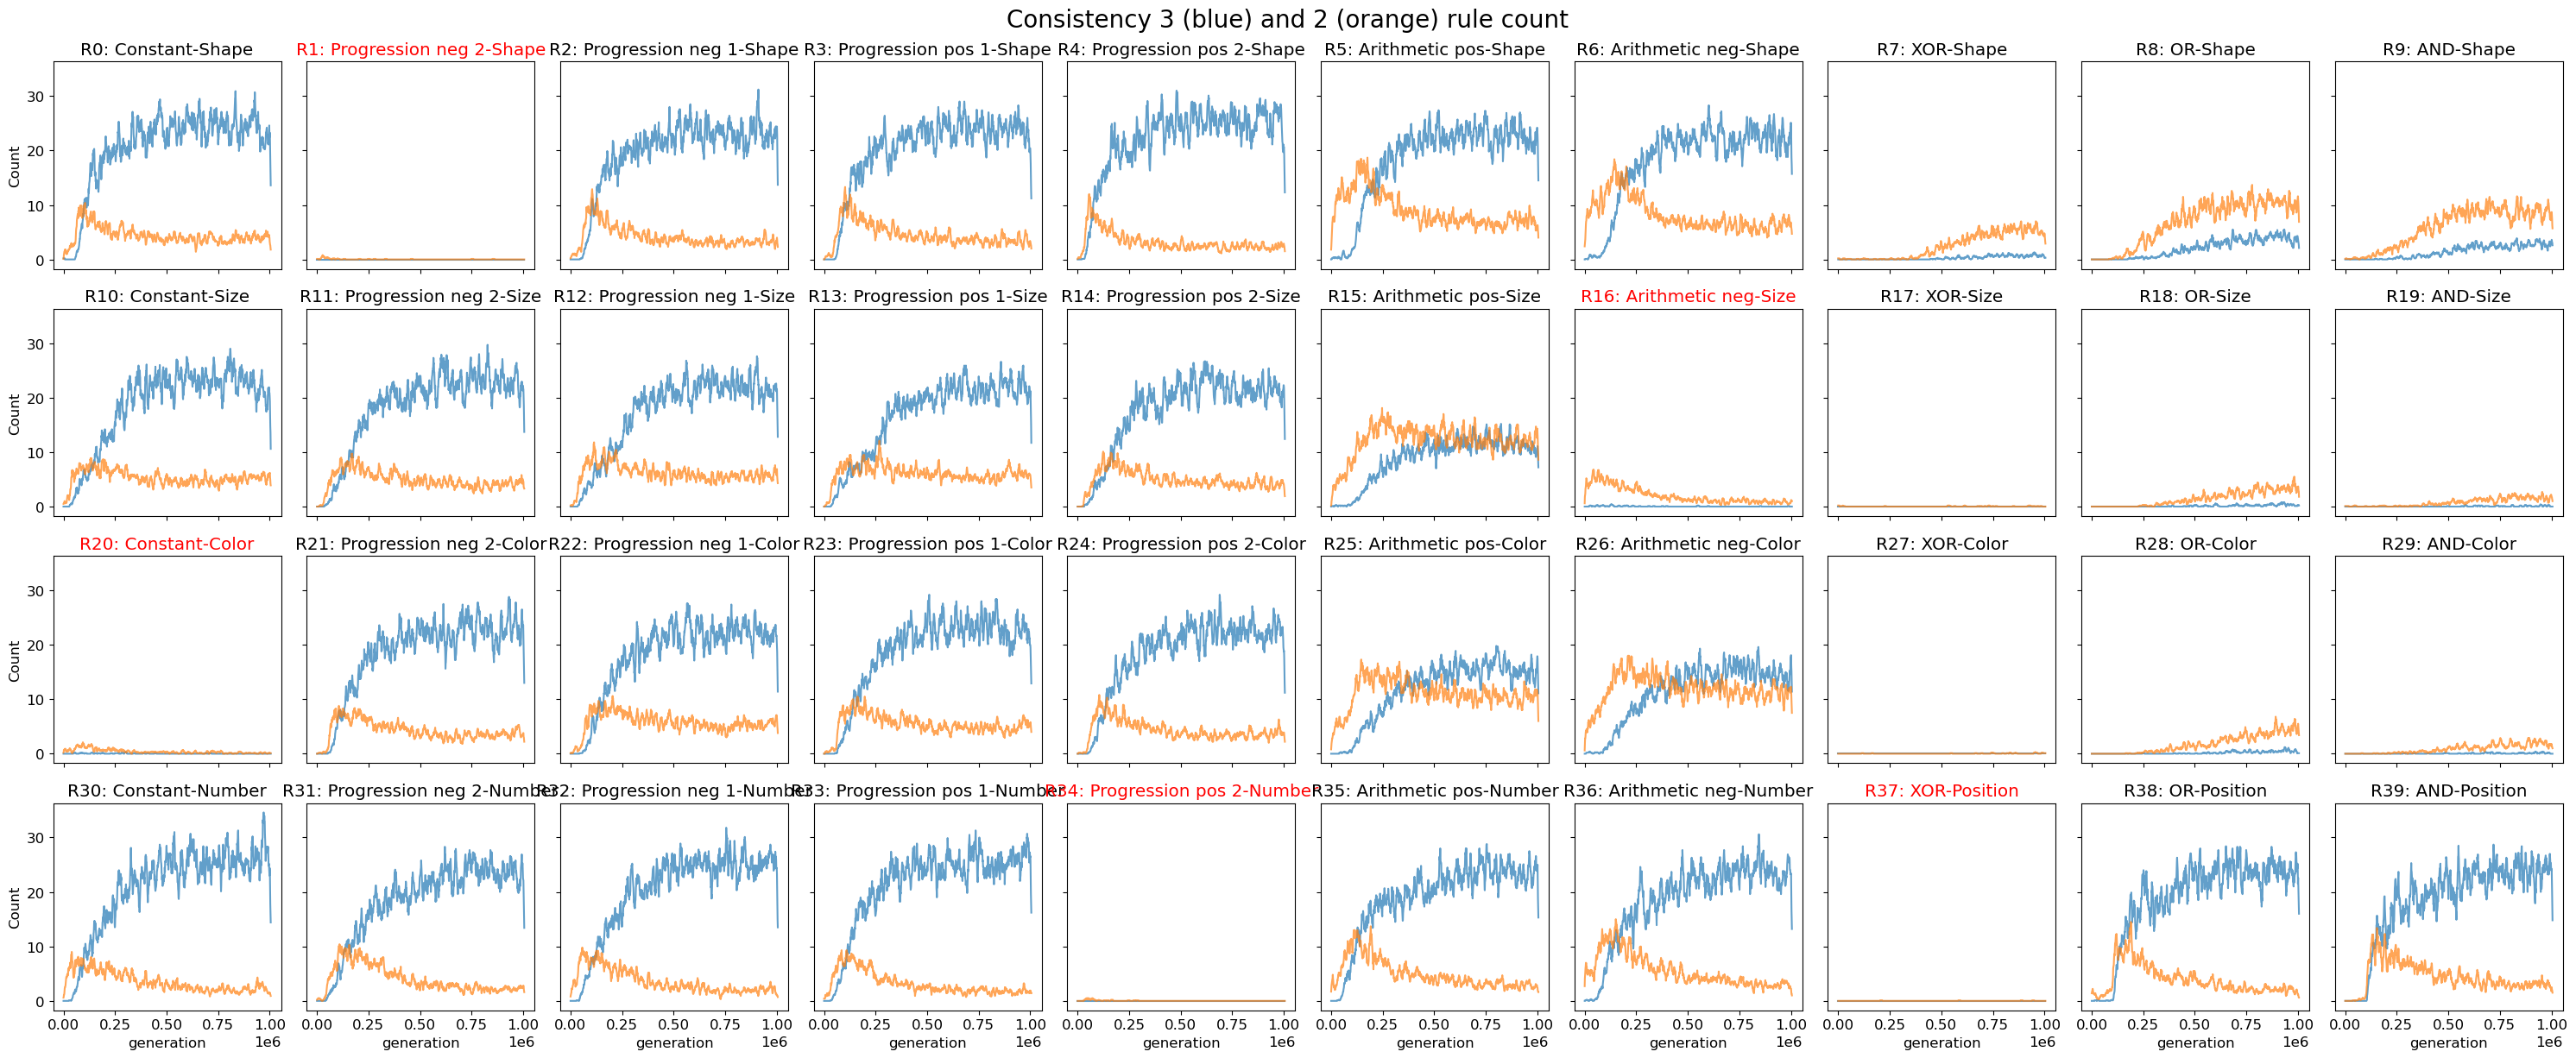

In [76]:
figh, axs = visualize_indiv_rule_dynam(cons3_rule_cnt_mat, conv_wid=10,
                                       titlestr="Consistency 3 (blue) and 2 (orange) rule count", )
figh, axs = visualize_indiv_rule_dynam(cons2_rule_cnt_mat, conv_wid=10,
                                       titlestr="Consistency 3 (blue) and 2 (orange) rule count", axs=axs)

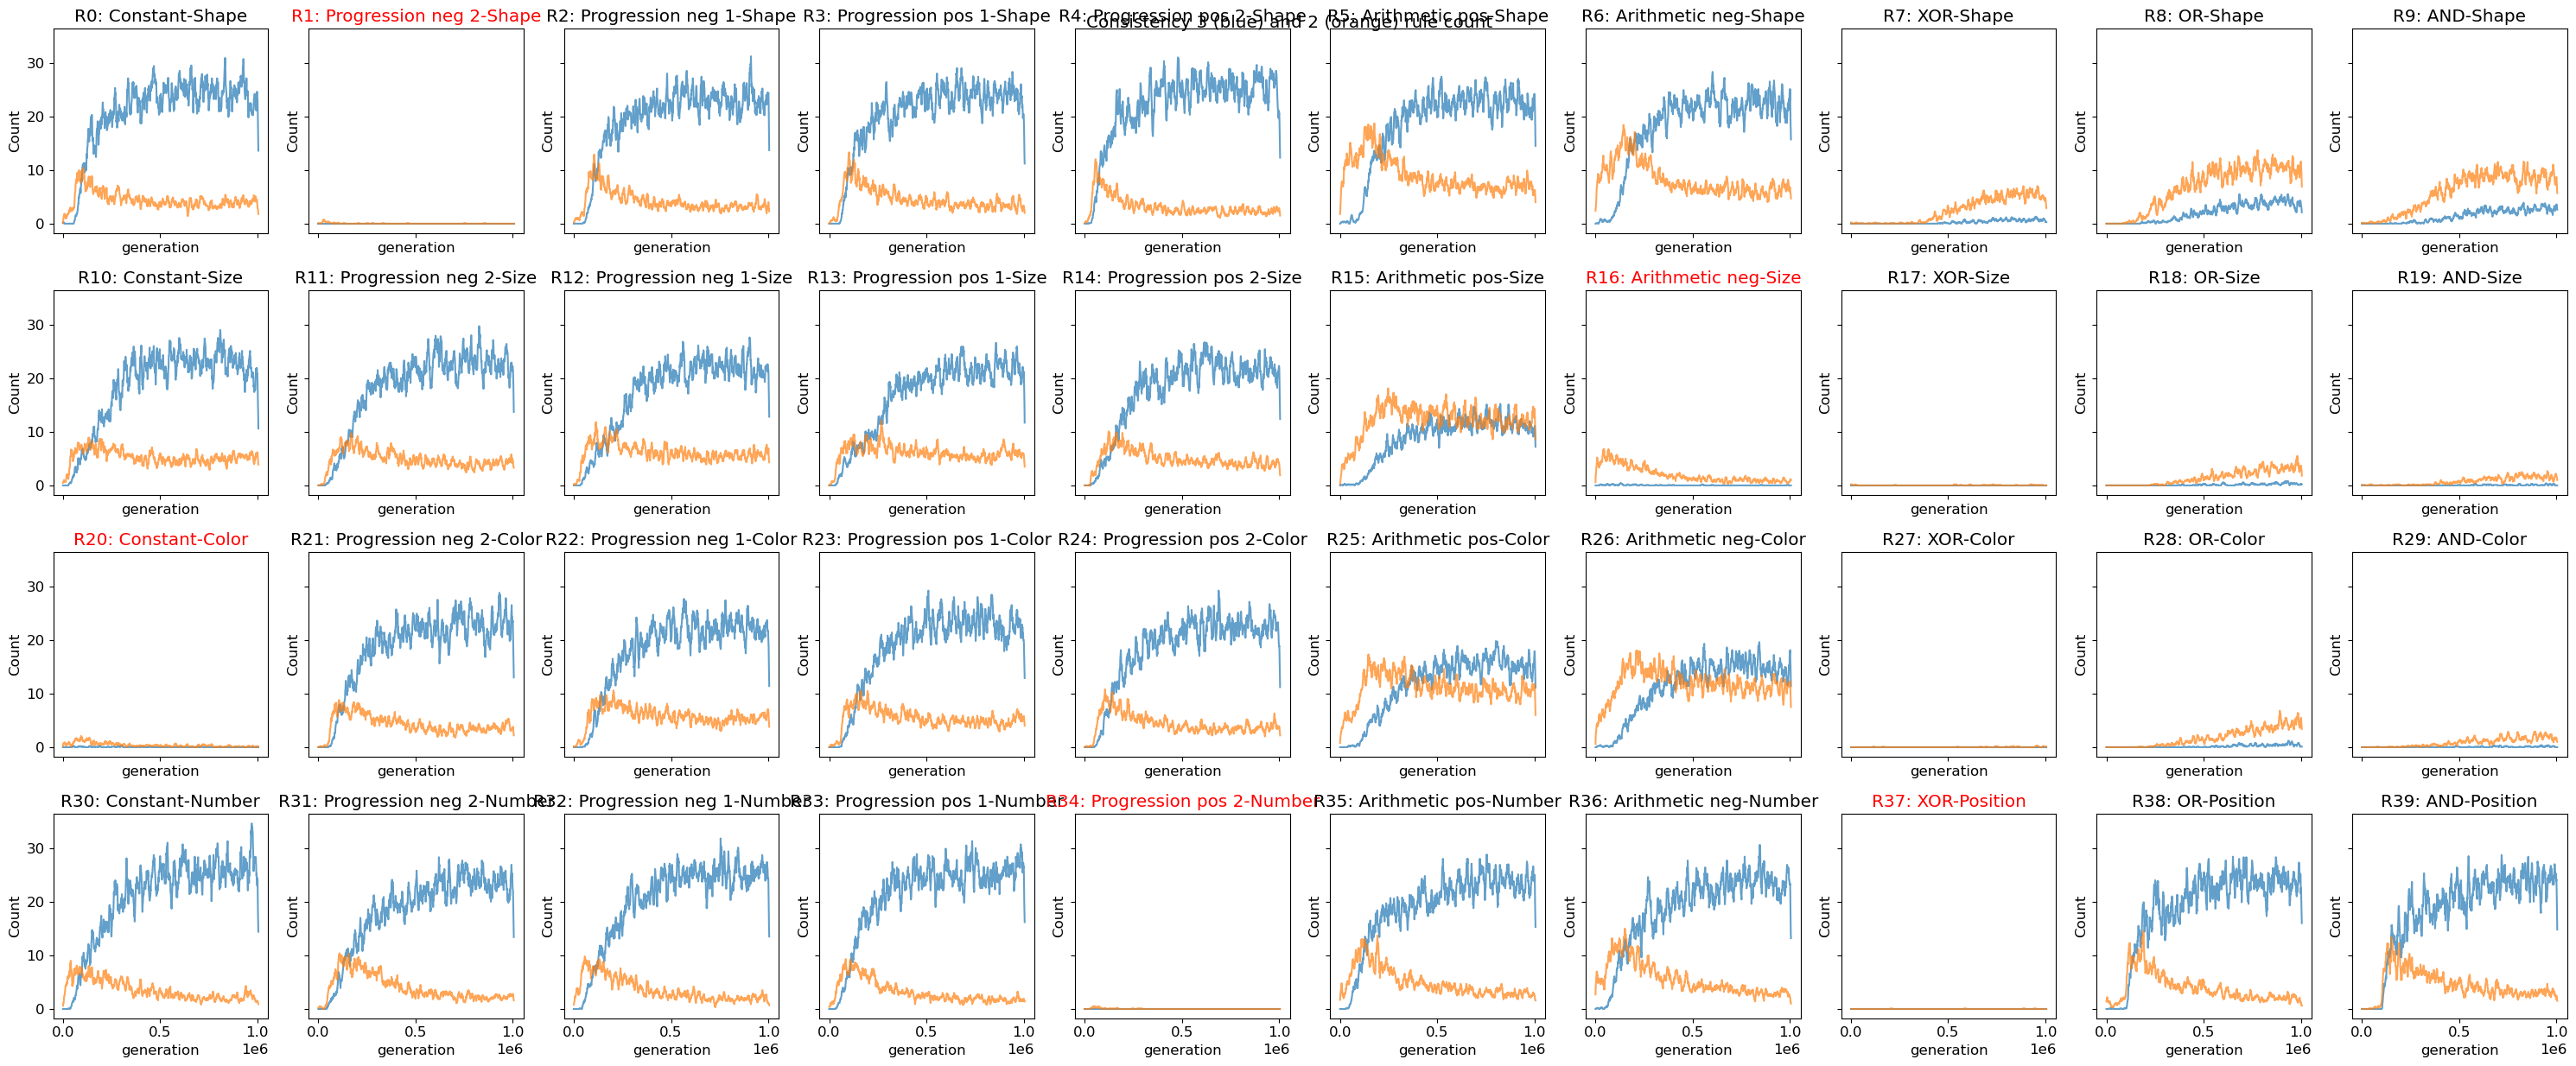

In [63]:
# remove top and right spines from plot with plt
plt.rcParams.update({'font.size': 12})
conv_wid = 10
figh, axs = plt.subplots(4, 10, figsize=(30, 12.5), sharex=True, sharey=True)
axs_f = axs.flatten()
for i in range(40):
    ax = axs_f[i]
    # smooth the curve
    smooth_rule_cnt = np.convolve(cons3_rule_cnt_mat[:,i], np.ones(conv_wid)/conv_wid, mode='same')
    ax.plot(data['epoch_list'], smooth_rule_cnt, alpha=0.7, )
    smooth_rule_cnt2 = np.convolve(cons2_rule_cnt_mat[:,i], np.ones(conv_wid)/conv_wid, mode='same')
    ax.plot(data['epoch_list'], smooth_rule_cnt2, alpha=0.7, )
    ax.set_title(f"R{i}: {entry_table[i]}")
    # change the font color of title to red
    if i in [1, 16, 20, 34, 37]:
        ax.title.set_color('red')
    ax.set_xlabel("generation")
    ax.set_ylabel("Count")
plt.tight_layout()
plt.suptitle("Consistency 3 (blue) and 2 (orange) rule count")
plt.show()